In [9]:
%matplotlib inline

from pathlib import Path
from sklearn.cross_validation import LeaveOneOut

from menpo.feature import no_op, hog, igo
from menpo.image import base
from menpo.io import export_image
from menpo.shape import PointCloud, bounding_box, mean_pointcloud
from menpo.visualize import print_progress
from menpofit.aam import LucasKanadeAAMFitter, WibergForwardCompositional
from menpofit.aam import PatchAAM
from menpofit.atm import ForwardCompositional, InverseCompositional #giusto per il salva, da modificare
from menpofit.fitter import noisy_shape_from_bounding_box, align_shape_with_bounding_box
from menpowidgets import visualize_fitting_result, visualize_images


import menpo.io as mio
import numpy as np
import cv2
import os

In [2]:
# Definisco la funzione SALVA che mi serve per esportare le immagini con le forme
# opportunamente rasterizzate.

def salva(fittato,numfo = 1, way = '/Users/mbacal0/Desktop/12ott/', OV=True):
    nome = str(numfo)
    way = way + nome + '/'
    if not os.path.exists(way):
        os.makedirs(way)
    evo = fittato.shapes
    img = fittato.image
    if fittato.gt_shape:
        img.landmarks['gt'] = fittato.gt_shape
    else:
        img.landmarks['gt'] = PointCloud([[0,0],[1,1]])
    k=0
    for s in evo:
        img.landmarks['temp'] = s
        img_temp = img.rasterize_landmarks(group = ['gt','temp'], line_colour = ['y','r'])
        export_image(img_temp, way + str(k) + '.jpg', overwrite=OV)
        k += 1
    img.landmarks['temp'] = fittato.final_shape
    img_temp = img.rasterize_landmarks(group = ['gt','temp'], line_colour = ['y','r'])
    return 'SGC'

def salvafinale(fittato,nome='test', way = '/Users/maurobacaloni/Desktop/Risultati/', OV=True):
    if not os.path.exists(way):
        os.makedirs(way)
    evo = fittato.shapes
    img = fittato.image
    if fittato.gt_shape:
        img.landmarks['gt'] = fittato.gt_shape
    else:
        img.landmarks['gt'] = PointCloud([[0,0],[1,1]])
    img.landmarks['finale'] = fittato.final_shape
    img_temp = img.rasterize_landmarks(group = ['gt','finale'], line_colour = ['b','r'])
    export_image(img_temp, way + nome + '.jpg', overwrite=OV)
    return 'SGC'



In [3]:
def landamarkizza(cloud_sx,cloud_dx, img, pathh = '/Users/maurobacaloni/Desktop/risultati/'):
    # cloud_sx e cloud_dx devono essere i risultati finali del fitting, con 44 pti ciascuno (40 di dente, 4 di skel della polpa) e img è l'immagine originale, da salvare e da usare per avere il nome e quindi l'età.
    if not os.path.exists(pathh):
        os.makedirs(pathh)
    if not os.path.exists(pathh + 'landmarks/'):
        os.makedirs(pathh + 'landmarks')
    nome = img.path
    nomes = str(nome)
    name = nomes[41:-4]
    export_image(img, pathh + name + '.jpg', overwrite=False)
    dati = open(pathh + 'landmarks/' + name + '.jpg_OPT.ljson', "w")
    clSX = cloud_sx.final_shape.points
    clDX = cloud_dx.final_shape.points
    #Inizio la stringa
    sr = '\x7B "landmarks": \x7B "points" : ['
    for i in np.arange(44):
        sr = sr + '[' + str(clSX[i][0]) + ',' + str(clSX[i][1]) + '],'
    for i in np.arange(44):
        sr = sr + '[' + str(clDX[i][0]) + ',' + str(clDX[i][1]) + ']'
        if i!=43:
            sr = sr + ','
    sr = sr + '], "connectivity": [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13],[13,14],[14,15],[15,16],[16,17],[17,18],[18,19],[19,20],[20,21],[21,22],[22,23],[23,24],[24,25],[25,26],[26,27],[27,28],[28,29],[29,30],[30,31],[31,32],[32,33],[33,34],[34,35],[35,36],[36,37],[37,38],[38,39],[39,0],[40,41],[41,42],[42,43],[44,45],[45,46],[46,47],[47,48],[48,49],[49,50],[50,51],[51,52],[52,53],[53,54],[54,55],[55,56],[56,57],[57,58],[58,59],[59,60],[60,61],[61,62],[62,63],[63,64],[64,65],[65,66],[66,67],[67,68],[68,69],[69,70],[70,71],[71,72],[72,73],[73,74],[74,75],[75,76],[76,77],[77,78],[78,79],[79,80],[80,81],[81,82],[82,83],[83,44],[84,85],[85,86],[86,87]]'
    sr = sr + '\x7D , "labels": [ \x7B "label":"toothSX", "mask":'
    sr = sr + '[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]'
    sr = sr + '\x7D,\x7B"label":"toothDX","mask":'
    sr = sr + '[44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87]\x7D,\x7B "label":"all","mask":'
    sr = sr + '[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87]'
    sr = sr + '\x7D ], "version":2\x7D'
    dati.write(sr)
    dati.close()
    return

In [4]:
# Acquisisco tutti i singoli canini segmentati della cartella "train"
# e vanno nella variabile train_set, opportunamente tagliati.

train_set = []
bb_sx, bb_dx = [], []
pp0 = '/Users/maurobacaloni/GoogleDrive/phd/OPT/'
pp = Path(pp0)
croppi = 0.15
for i in print_progress(mio.import_images(pp)):
    nome = i.path
    nome = str(nome)
    nome = nome[41:-4]
    percorso = pp0 + 'landmarks_skel_opt/' + nome + '.jpg_OPT.ljson'
    path_temp = Path(percorso)
    if os.path.exists(percorso):
        if i.n_channels ==3:
            i = i.as_greyscale(mode='luminosity')
        land_temp = mio.import_landmark_file(path_temp)
        i.landmarks['SX'] = land_temp.with_labels('toothSX')
        i.landmarks['DX'] = land_temp.with_labels('toothDX')
        bb_sx.append(i.landmarks['SX'].lms)
        bb_dx.append(i.landmarks['DX'].lms)
        bbsxtemp = (i.landmarks['SX'].lms).bounding_box()
        bbdxtemp = (i.landmarks['DX'].lms).bounding_box()
        isx = i.crop_to_landmarks_proportion(croppi, group = 'SX')
        idx = i.crop_to_landmarks_proportion(croppi, group = 'DX')
        isx.landmarks['tooth'] = isx.landmarks['SX']
        idx.landmarks['tooth'] = idx.landmarks['DX']
        
        
        del isx.landmarks['SX'], isx.landmarks['DX']
        del idx.landmarks['SX'], idx.landmarks['DX']
        
        train_set.append(isx)
        train_set.append(idx)        
mean_bb_sx = mean_pointcloud(bb_sx[::])
mean_bb_dx = mean_pointcloud(bb_dx[::])
bb_sx = mean_bb_sx.bounding_box()
bb_dx = mean_bb_dx.bounding_box()

[====================] 100% (86/86) - done.                                     


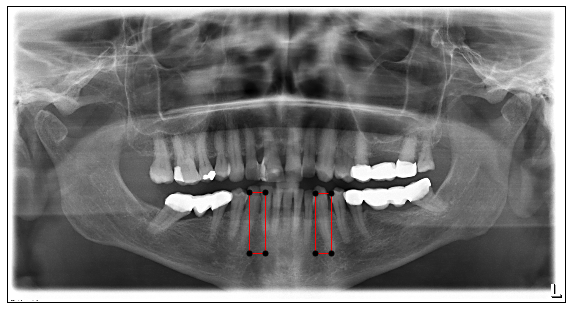

In [5]:
# Dal training set, collezione dei bounding box, media per vedere se puo essere utile come bounding box iniziale

#vertex_A_X = [770,790,780,800,800,800,820,790,790,810,790,790,790]
#vertex_C_X = [770,790,790,810,800,800,810,800,810,830,830,800,800]

#vertex_A_Y = [1000,1040,1000,1010,1090,1090,1060,1020,1040,1040,1020,1050,1020]
#vertex_C_Y = [1330,1350,1350,1350,1370,1360,1360,1340,1350,1350,1350,1330,1330]

#vertex_B_X = [1100,1120,1130,1130,1130,1130,1130,1100,1120,1120,1100,1100,1050]
#vertex_D_X = [1100,1100,1100,1100,1120,1070,1090,1090,1090,1090,1090,1070,1050]

#vertex_B_Y = [1120,1130,1100,1100,1190,1190,1160,1100,1140,1140,1130,1150,1110]
#vertex_D_Y = [1450,1420,1450,1430,1460,1440,1440,1430,1440,1440,1420,1420,1400]

#bb_sx = bounding_box((1.05*np.mean(vertex_A_X),1.03*np.mean(vertex_A_Y)),(.95*np.mean(vertex_B_X),.98*np.mean(vertex_B_Y)))
#bb_dx = bounding_box((1.05*np.mean(vertex_C_X),1.05*np.mean(vertex_C_Y)),(.95*np.mean(vertex_D_X),.95*np.mean(vertex_D_Y)))
test = mio.import_images('/Users/maurobacaloni/GoogleDrive/phd/OPT/', max_images=1)
test[0].view()
bb_sx.view()
bb_dx.view()

QUI INIZIA IL LAVORO CLASSICO, creo un modello, il fitter, l'archivio e simulo

In [6]:
# Costruisco l'Active Appearance Model con le immagini train_set

aam = PatchAAM(
    train_set,
    group='tooth',
    holistic_features = [igo, hog, hog],
    scales = [0.2,0.6,1],
    #patch_shape = [25,15],
    max_appearance_components = 200,
    #max_shape_components = 26,
    verbose = True
    
)



- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
  - Scale 2: Done
                                                              

In [7]:
aam_fitter = LucasKanadeAAMFitter(
    aam,
    n_shape = [0.2,0.4,.5],
    n_appearance = [.5,.6,.8]
)



In [12]:
archivio = []
for i in print_progress(mio.import_images('/Users/maurobacaloni/GoogleDrive/phd/OPT/')):
    if i.n_channels ==3:
        i = i.as_greyscale(mode = 'luminosity')
    if not i.has_landmarks:
        archivio.append(i)
    
tester = archivio      

[====================] 100% (86/86) - done.                                     


In [13]:
res_sx = []
res_dx = []

for i in print_progress(np.arange(len(tester))):
    res_sx.append(aam_fitter.fit_from_bb(tester[i],bb_sx, max_iters=[10,10,35]))
    res_dx.append(aam_fitter.fit_from_bb(tester[i],bb_dx, max_iters=[10,10,35]))


[====================] 100% (86/86) - done.                                     


QUI INVECE PROVO A VEDERE EVENTUALI DIFFERENZE TRA ALGORITMI

In questa provo a prendere un'unica immagine già segmentata e vedere come cambia il risultato cambiando l'algoritmo.

In [15]:
from menpofit.aam import AlternatingForwardCompositional, AlternatingInverseCompositional
from menpofit.aam import ModifiedAlternatingForwardCompositional, ModifiedAlternatingInverseCompositional
from menpofit.aam import ProjectOutForwardCompositional, ProjectOutInverseCompositional
from menpofit.aam import SimultaneousForwardCompositional, SimultaneousInverseCompositional
from menpofit.aam import WibergForwardCompositional, WibergInverseCompositional

algoritmiF = [AlternatingForwardCompositional, ModifiedAlternatingForwardCompositional, ProjectOutForwardCompositional, SimultaneousForwardCompositional, WibergForwardCompositional]
algoritmiI = [AlternatingInverseCompositional, ModifiedAlternatingInverseCompositional, ProjectOutInverseCompositional, SimultaneousInverseCompositional, WibergInverseCompositional]

test = mio.import_image('/Users/maurobacaloni/GoogleDrive/phd/OPT/train_skel/BALERCIA_A_28.jpg')
te_sx = test.landmarks['LJSON'].with_labels(labels = 'toothSX')
te_dx = test.landmarks['LJSON'].with_labels(labels = 'toothDX')

aam = PatchAAM(
    train_set,
    group='tooth',
    holistic_features = [igo, hog, hog],
    scales = [0.2,0.6,1],
    #patch_shape = [25,15],
    max_appearance_components = 200,
    #max_shape_components = 26,
    verbose = True
)
res_sx = []
res_dx = []

for al in np.arange(len(algoritmiI)):
    aam_fitter = LucasKanadeAAMFitter(aam,lk_algorithm_cls = algoritmiI[al],n_shape = [0.2,0.4,.5],n_appearance = [.5,.6,.8])
    for al2 in np.arange(len(algoritmiF)):
        aam_fitter2= LucasKanadeAAMFitter(aam,lk_algorithm_cls = algoritmiF[al2],n_shape = [0.2,0.4,.5],n_appearance = [.5,.6,.8])
        res_sx_temp = aam_fitter.fit_from_bb(test,bb_sx, max_iters=[10,10,0], gt_shape=te_sx)
        res_sx.append(aam_fitter2.fit_from_shape(test,res_sx_temp.final_shape, max_iters=[0,0,20],gt_shape=te_sx))
        #res_dx.append(aam_fitter.fit_from_bb(test,bb_dx, max_iters=[10,10,35], gt_shape=te_dx))
        print('\n fatto un algoritmo \n')
    print('\n fatto un ciclo di algoritmi forward')

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
  - Scale 2: Done
                                                              

In [14]:
for i in print_progress(np.arange(len(res_sx))):
    nome = str(i)
    salvafinale(res_sx[i],nome='SX'+str(i),OV=True, way='/Users/maurobacaloni/Desktop/BLA/')
    #salvafinale(res_dx[i],nome='DX'+str(i),OV=True, way='/Users/maurobacaloni/Desktop/BLA/')

[====================] 100% (25/25) - done.                                     


    NEW STUFF
    
Vado a vedere differenze tra le varie features

In [13]:
from menpo.feature import es, igo, hog, fast_dsift, lbp
from menpofit.aam import HolisticAAM


In [14]:
archivio = []
for i in print_progress(mio.import_images('/Users/maurobacaloni/GoogleDrive/phd/OPT/')):
    if i.n_channels ==3:
        i = i.as_greyscale(mode = 'luminosity')
    if not i.has_landmarks:
        archivio.append(i)
    
tester = archivio[15:18]

[====================] 100% (86/86) - done.                                     


In [24]:
tester = archivio

In [ ]:
test = mio.import_image('/Users/maurobacaloni/GoogleDrive/phd/OPT/train_skel/BALERCIA_A_28.jpg')
test = test.as_greyscale(mode='luminosity')

#te_sx = test.landmarks['LJSON'].with_labels(labels = 'toothSX')
#te_dx = test.landmarks['LJSON'].with_labels(labels = 'toothDX')

aam0 = HolisticAAM(train_set,group='tooth',holistic_features = es, scales=[0.3,.7], verbose=True)

aam1 = PatchAAM(
    train_set,
    group='tooth',
    holistic_features = [igo, hog, hog],
    scales = [0.2,0.6,1],
    #patch_shape = [25,15],
    max_appearance_components = 200,
    #max_shape_components = 26,
    verbose = True
)

fitter0 = LucasKanadeAAMFitter(aam0, n_shape=[.2,.8])
fitter1 = LucasKanadeAAMFitter(aam1, n_shape=[.2,.6,.9])

res_sx = []
res_dx = []
print('\n fatti i fitter di merda\n')
for i in print_progress(np.arange(len(tester))):
    fi0_sx = fitter0.fit_from_bb(tester[i],bb_sx, max_iters=15)
    fi1_sx = fitter1.fit_from_shape(tester[i],fi0_sx.final_shape,max_iters=[10,10,15])
    res_sx.append(fi0_sx)
    res_sx.append(fi1_sx)
    fi0_dx = fitter0.fit_from_bb(tester[i],bb_dx, max_iters=15)
    fi1_dx = fitter1.fit_from_shape(tester[i],fi0_dx.final_shape,max_iters=[10,10,15])
    res_dx.append(fi0_dx)
    res_dx.append(fi1_dx)


- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Scaling images: [          ] 1% (1/56) - 00:00:00 remaining        

//anaconda/lib/python3.5/site-packages/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)


  - Scale 1: Done
- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Computing feature space: [====      ] 46% (26/56) - 00:00:25 remaining

In [23]:
for i in print_progress(np.arange(len(res_sx))):
    nome = str(i)
    salvafinale(res_sx[i],nome='SX'+str(i),OV=True, way='/Users/maurobacaloni/Desktop/BLA/')
    salvafinale(res_dx[i],nome='DX'+str(i),OV=True, way='/Users/maurobacaloni/Desktop/BLA/')

[====================] 100% (6/6) - done.                                       
